In [ ]:
import numpy as np
import astropy as ap
from astropy.io import fits
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import scipy as sp
from astropy import units as u
import pandas as pd
import wotan
from wotan import flatten
from astropy.stats import sigma_clip
from astropy.timeseries import TimeSeries,aggregate_downsample
from sklearn.exceptions import ConvergenceWarning
import warnings
from plotly import express as px
from plotly import graph_objects as go
plt.rcParams["figure.figsize"] = (25,10)

Welcome to the Second Notebook here we want to get a better view of the Transit than before. To do this we do the detrending of the Data twice once to get a rough overview of the Data and a bit of knowledge about where the transits are. Then we use this to mask the Transits and detrend the Data ignoring the masked transits and then we apply this to the entire data. This should provide us with a much clearer umage of the Transits.

In [ ]:
Data = fits.open("Data/hlsp_tess-data-alerts_tess_phot_00261136679-s01_tess_v1_lc.fits",)
t0 = Data[1].header["TSTART"] #Starting Time of Measurement
tref = Data[1].header["BJDREFI"] #Reference Time
tcomb = t0+tref
TS = TimeSeries.read("Data/hlsp_tess-data-alerts_tess_phot_00261136679-s01_tess_v1_lc.fits",format="tess.fits",) #Get all the Values into a Time Series
Flux_TS = TS["time","pdcsap_flux"] # Just the PDCSAP FLux to make the Time Series Smaller for Simplicity Sake and for Speed

C:\Users\diese\AppData\Roaming\Python\Python38\site-packages\astropy\timeseries\io\kepler.py:77: UserWarning: Ignoring 815 rows with NaN times
  warnings.warn('Ignoring {} rows with NaN times'.format(np.sum(nans)))


We use Sigma Clipping 3-5$\sigma$ where $3 \sigma$ is a conservative but appropriate approach [Jones 2020](https://iopscience.iop.org/article/10.3847/2041-8213/ab8f2b/pdf)

In [ ]:
clip = sigma_clip(Flux_TS["pdcsap_flux"],sigma=3)
mask = ~np.ma.getmask(clip)
Flx = TimeSeries(time=Flux_TS["time"][mask],data=Flux_TS["pdcsap_flux"][mask].reshape(-1,1),names=["Flux"])

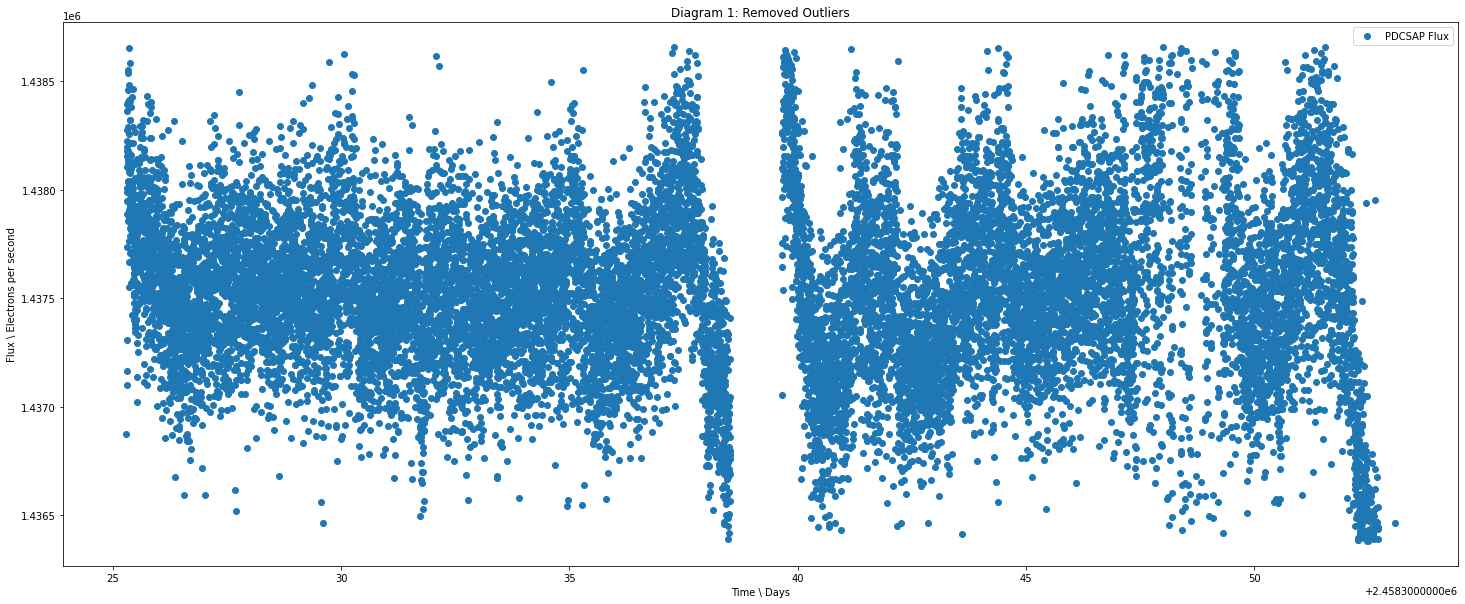

In [ ]:
plt.title("Diagram 1: Removed Outliers")
plt.plot(Flx.time.jd,Flx["Flux"],"o",label="PDCSAP Flux")
plt.ylabel(r"Flux \ Electrons per second")
plt.xlabel(r"Time \ Days")
plt.legend()

As determined before were gonna use the Gaussian Process with a kernel Size of 4.

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    Flx["gp-rough"] = flatten(Flx.time.jd, Flx["Flux"],method='gp',kernel="squared_exp",kernel_size=4)

In [ ]:
Flx.write("Save.csv",overwrite=True) #Save the Flx values to use in another Notebook without having to rerun.

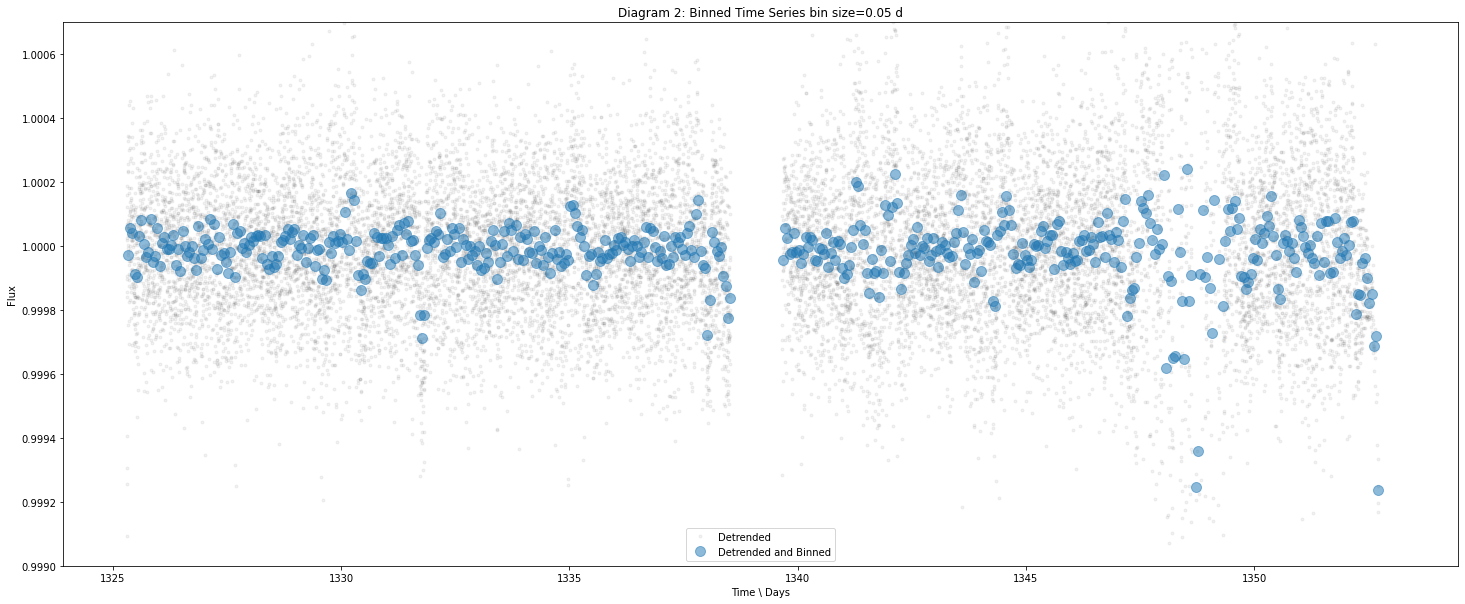

In [ ]:
bin_test = aggregate_downsample(Flx,time_bin_size=0.05*u.d)

plt.title("Diagram 2: Binned Time Series bin size=0.05 d")
plt.plot(Flx.time.jd-tref,Flx["gp-rough"],".k",alpha=0.05,label="Detrended")
plt.plot(bin_test.time_bin_center.jd-tref,bin_test["gp-rough"],"o",markersize=10,alpha=0.5,label="Detrended and Binned")

plt.ylabel("Flux")
plt.xlabel("Time \ Days")
plt.ylim(0.9990,1.0007)
plt.legend()

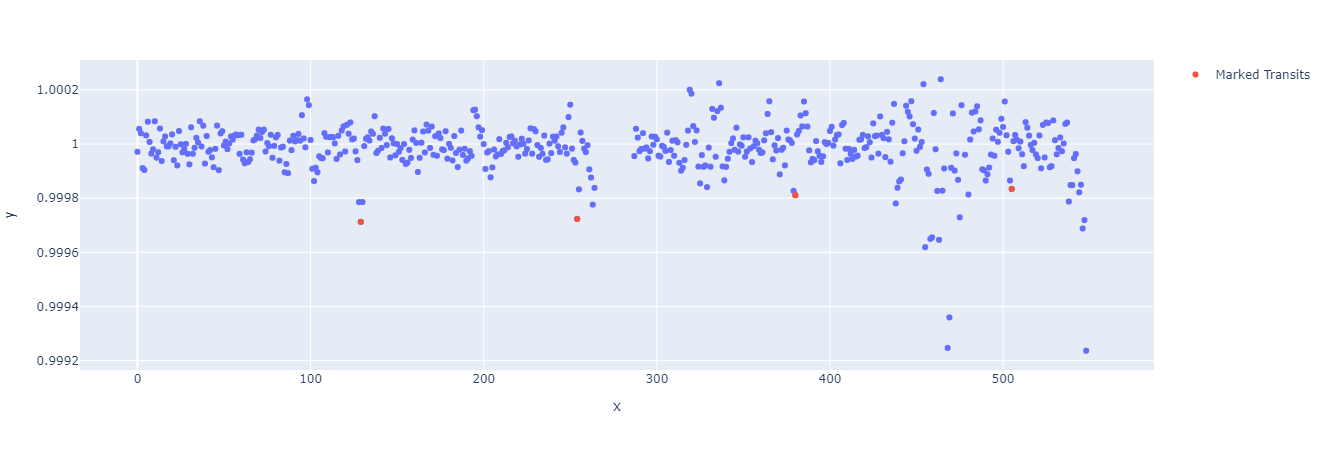

In [ ]:
fig = px.scatter(y=bin_test["gp-rough"][:-1])#,x=bin_test.time_bin_center.jd-t0-2457000)
fig.add_trace(go.Scatter(x=[129,254,380,505],y = [bin_test["gp-rough"][129],bin_test["gp-rough"][254],bin_test["gp-rough"][380],bin_test["gp-rough"][505]],mode="markers",name="Marked Transits"))
fig.show()

We simply estimate the periods between to transits by calculating the difference between the two indexes we could identify as Transits here. For a more intricate calculation of the Periods see [Periods.ipynb](Periods.ipynb) where we use Periodograms which can be used to find the Periods even in very noisy data.

In [ ]:
period = np.float64(bin_test.time_bin_center.jd[129]) - np.float64(bin_test.time_bin_center.jd[254])
period

-6.25

Now we try to refine this detrending by masking the Transits, around:

In [ ]:
t_1=bin_test.time_bin_center.jd[129]-tref
t_2=bin_test.time_bin_center.jd[254]-tref
t_3=bin_test.time_bin_center.jd[380]-tref
t_4=bin_test.time_bin_center.jd[505]-tref

transit_times = np.array([t_1,t_2,t_3,t_4])
print(transit_times)

[1331.77198328 1338.02198328 1344.32198328 1350.57198328]


In [ ]:
def time_mask(time,timestamps,pm):
    mask = np.zeros(len(time),dtype=bool)
    for t in timestamps:
        mask |= (time<(t+pm)) & (time>(t-pm))
    return mask

In [ ]:
trans_mask =  time_mask(Flx.time.jd-tref,transit_times,0.2)
trans_mask

array([False, False, False, ..., False, False, False])

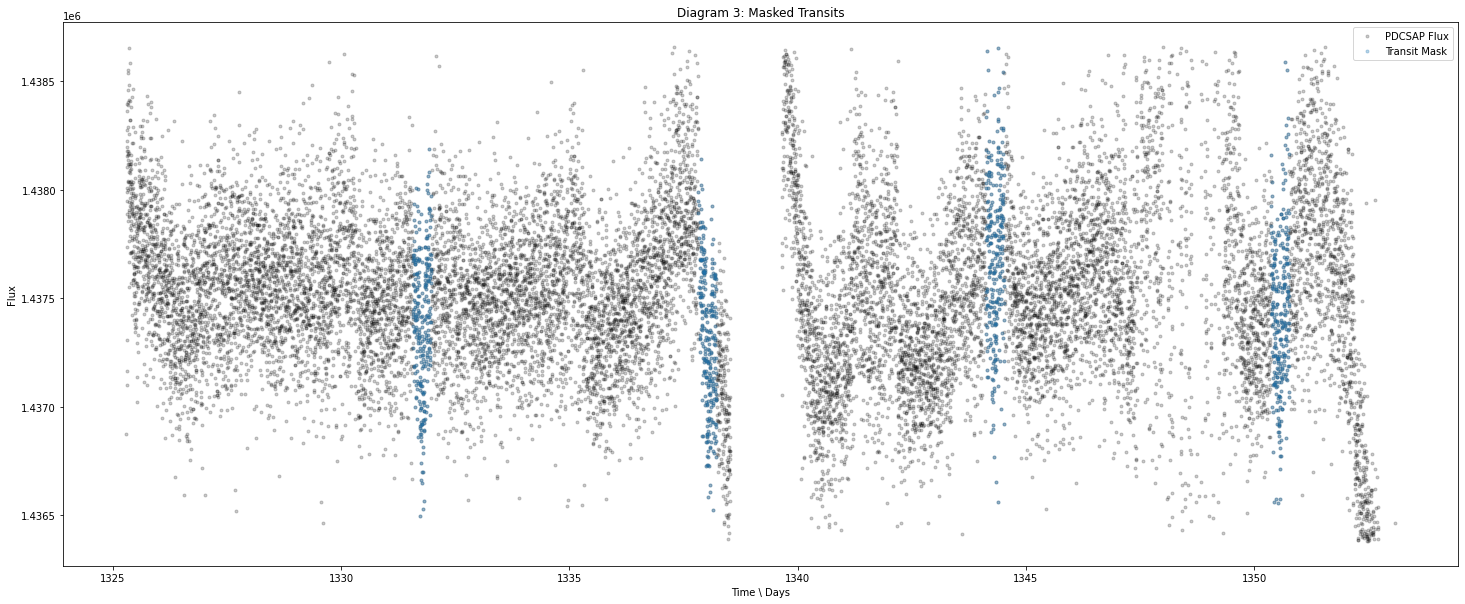

In [ ]:
plt.title("Diagram 3: Masked Transits")
plt.plot(Flx.time.jd-tref,Flx["Flux"],".k",alpha=0.2,label="PDCSAP Flux")
#plt.plot(bin_test.time_bin_center.jd-tref,bin_test["gp-rough"],"o",markersize=10,alpha=0.5,label="Detrended and Binned")
plt.plot(Flx.time.jd[trans_mask]-tref,Flx["Flux"][trans_mask],".",alpha=0.3,label="Transit Mask")
plt.ylabel("Flux")
plt.xlabel("Time \ Days")
#plt.ylim(0.9990,1.0007)
plt.legend()

We now roughly determined the Transit Signals and have created a mask we will now detrend using this mask and then detrend all the values with it.

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    Flx["gp-detrend"],detrend_mask = flatten(Flx.time.jd, Flx["Flux"],method='gp',kernel="squared_exp",kernel_size=4,mask=trans_mask,return_trend=True)

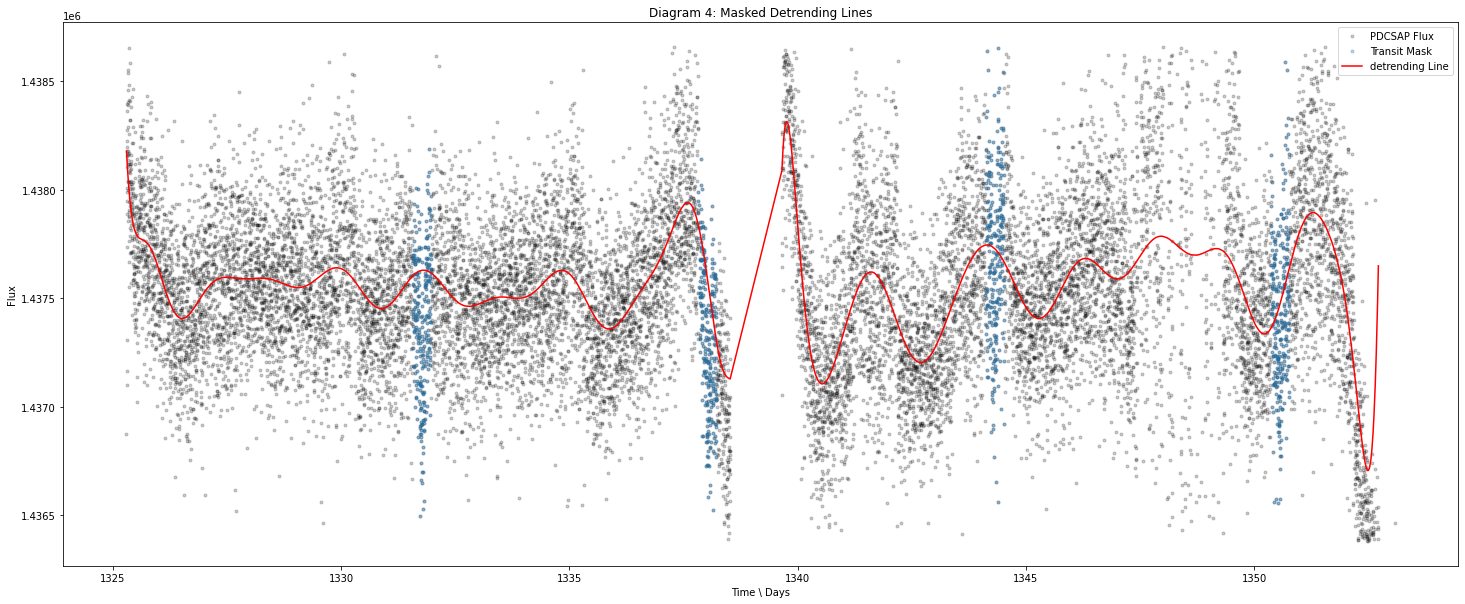

In [ ]:
plt.title("Diagram 4: Masked Detrending Lines")
plt.plot(Flx.time.jd-tref,Flx["Flux"],".k",alpha=0.2,label="PDCSAP Flux")
#plt.plot(bin_test.time_bin_center.jd-tref,bin_test["gp-rough"],"o",markersize=10,alpha=0.5,label="Detrended and Binned")
plt.plot(Flx.time.jd[trans_mask]-tref,Flx["Flux"][trans_mask],".",alpha=0.3,label="Transit Mask")
plt.plot(Flx.time.jd[:-1]-tref,detrend_mask[:-1],"-r",label="detrending Line")
plt.ylabel("Flux")
plt.xlabel("Time \ Days")
#plt.ylim(0.9990,1.0007)
plt.legend()

This here shows us the detrending Line that we get when the transits are masked. Now we detrend and Downsample the Data to get a flat curve of our Transits.

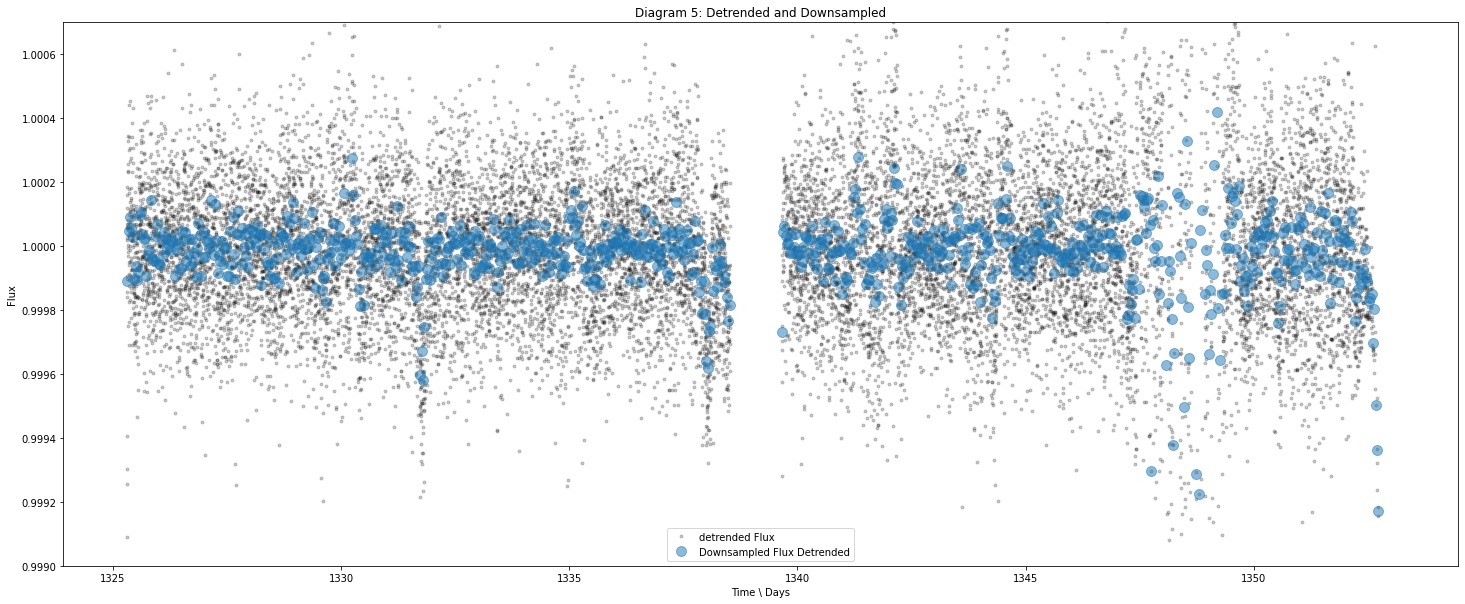

In [ ]:
ds_1 = aggregate_downsample(Flx,time_bin_size=0.03*u.d)

plt.title("Diagram 5: Detrended and Downsampled")
plt.plot(Flx.time.jd[:-1]-tref,Flx["gp-detrend"][:-1],".k",alpha=0.2,label="detrended Flux")
plt.plot(ds_1.time_bin_center.jd-tref,ds_1["gp-detrend"],"o", markersize=10,alpha=0.5,label="Downsampled Flux Detrended")
plt.ylabel("Flux")
plt.xlabel("Time \ Days")
plt.ylim(0.9990,1.0007)
plt.legend()

we have now detrended the data and we can nicely see most of the Transits.
We are using the Plotly Package to get an interactive View of the Data and determine the the Period abit better. An even better method would be using a Periodogram to find the Period, we show this in [Periods](Periods.ipynb).

In [ ]:
px.scatter(y=Flx["gp-detrend"])
period = np.abs(Flx.time.jd[4504]-Flx.time.jd[8857])
period

6.259623453952372

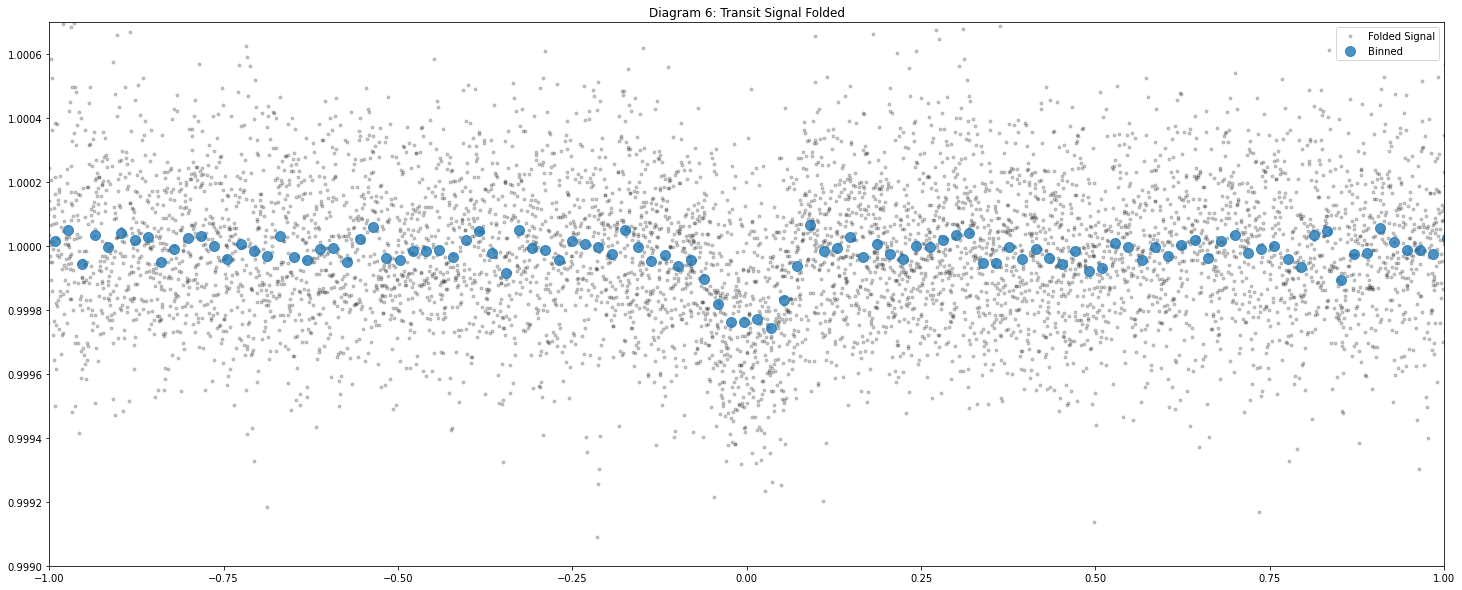

In [ ]:
Flx_fold = Flx.fold(period=period*u.d,epoch_time=Flx.time[4504])
bin_transit = aggregate_downsample(Flx_fold,time_bin_size=0.019*u.d)

plt.title("Diagram 6: Transit Signal Folded")
plt.plot(Flx_fold.time.jd,Flx_fold["gp-detrend"],".k",alpha=0.2,label="Folded Signal")
plt.plot(bin_transit.time_bin_center.jd,bin_transit["gp-detrend"],"oC0",markersize=10,alpha=0.8,label="Binned")
plt.ylim(0.9990,1.0007)
plt.xlim(-1,1)
plt.legend()

## Fiting

We are now turning to the Next Step Fitting of the Transit Data we shall look for models to Fit the Transit, we use the Process described in Carter 2004 Analysis of Exoplanetary Transit Light Curves


In [ ]:
from scipy.optimize import curve_fit
# without limb darkening
def transitcurve(t,tc,f0,d,tau,T):
    condlist = [np.abs(t-tc)<=(T/2-tau/2),((T/2-tau/2)<np.abs(t-tc)) & ((T/2+tau/2)>np.abs(t-tc)),np.abs(t-tc)>=(T/2+tau/2)]
    funclist = [f0-d,lambda t: (f0-d+d/tau*(np.abs(t-tc)-T/2+tau/2)),f0]
    return np.piecewise(t,condlist,funclist)

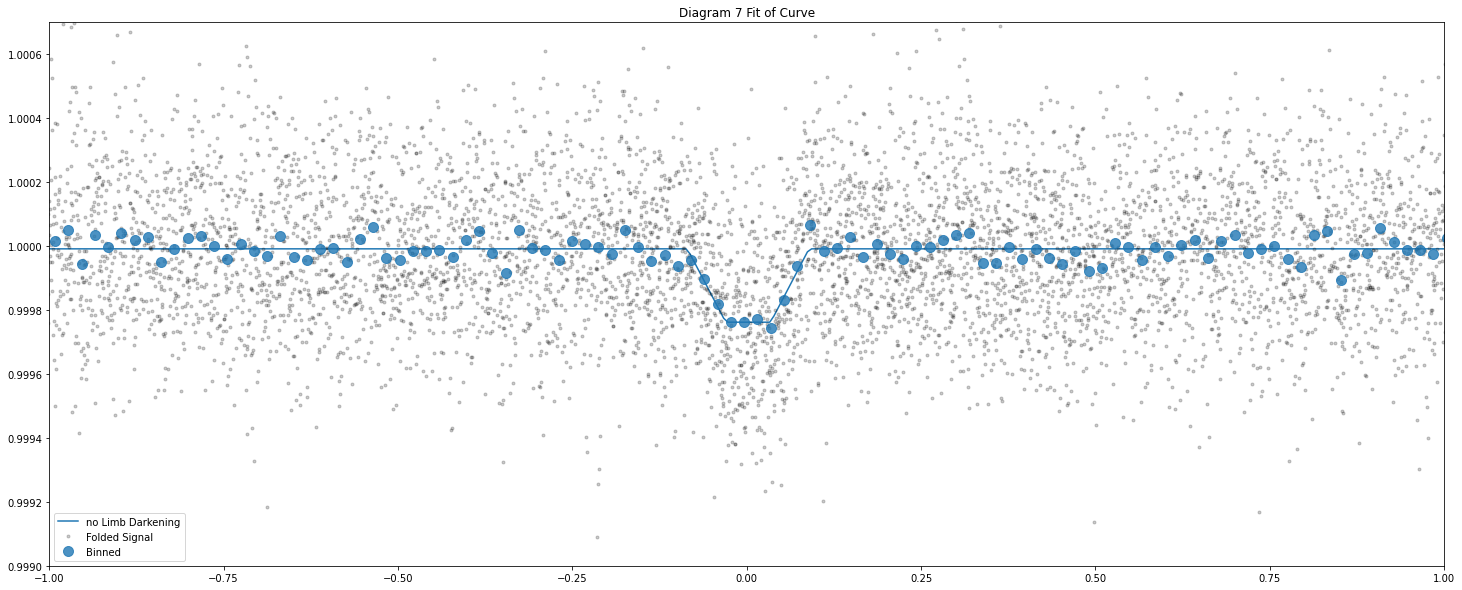

In [ ]:
test = np.linspace(-3,3,1000)
popt,pcov = curve_fit(transitcurve,bin_transit.time_bin_center.jd,bin_transit["gp-detrend"],p0=[0,1,0.0002,0.06,0.2]) #Fit with some initial guesses by reading the plot by hand

plt.title("Diagram 7 Fit of Curve")
plt.plot(test,transitcurve(test,*popt),label="no Limb Darkening")
plt.plot(Flx_fold.time.jd,Flx_fold["gp-detrend"],".k",alpha=0.2,label="Folded Signal")
plt.plot(bin_transit.time_bin_center.jd,bin_transit["gp-detrend"],"oC0",markersize=10,alpha=0.8,label="Binned")
plt.ylim(0.9990,1.0007)
plt.xlim(-1,1)
plt.legend()
#plt.savefig("Fit.jpg")

while this is without limb darkening we can still use it to get some rough estimates for our Planetary parameters.

In [ ]:
def getPlanet(P,tc,f0,d,tau,T): #calculate the Planetary Parameters out of our Abstract Parametrs
    r = np.sqrt(d/f0) #ratio of planet radius to star radius rp/rs 
    b = np.sqrt(1-r*T/tau) # impact parameter
    tau0 = np.sqrt(T*tau/(4*r))
    aR = P/(2*np.pi*tau0)
    
    print(f"r = {r}, b = {b}, a/R* = {aR}, t0 = {tc}, T_width = {T}")
    return r,b,aR

PlanetParams = getPlanet(period,*popt)

r = 0.01514539765143916, b = 0.9834000175868255, a/R* = 3.027751494195255, t0 = 0.0021573037229574905, T_width = 0.11940900503585043


In [ ]:
Sigma_r = np.abs(PlanetParams[0]-0.0170)/0.0012
Sigma_b = np.abs(PlanetParams[1]-0.92)/0.06
Sigma_aR = np.abs(PlanetParams[2]-6.85)/2.15
print(f"\n Sigma Diff r = {Sigma_r} \n Sigma Diff b = {Sigma_b} \n Sigma Diff a\R* = {Sigma_aR}")


 Sigma Diff r = 1.5455019571340352 
 Sigma Diff b = 1.0566669597804244 
 Sigma Diff a\R* = 1.7777900026998814


We can see the Parameters we got through our Fit coincide within less than 2 Sigma with the onese given in the Initial Data Report.

Now we want to introduce Limb Darkening in addition to our model. we thus define a model with Limb Darkening: we use [Analytic Ex Analytic Exoplanet T oplanet Transit Analysis, and Inv ansit Analysis, and Investigation int estigation into WASP,
Kepler, and Qatar System](https://crossworks.holycross.edu/cgi/viewcontent.cgi?article=1017&context=honors)

In [ ]:
from scipy.integrate import quad
import quadpy

def transit(t,tc,b,p,dt,gamma1,gamma2):
    """
    tc center of transit
    b impact parameter
    dt time fo tranit
    p rp/rs ratio planet radius to stellar radius
    """

    
    v = 2*np.sqrt((1+p)**2-b**2)/dt
    z = np.sqrt(v**2*(t-tc)**2+b**2)
    
    def specInt(func,a,b):
        if len(a) == 1:
            return quad(func,a,b)
        else:
            
            Ints = np.zeros(len(a))
            if type(b) == int:
                b = np.repeat(b,a.size)
            for i in range(len(a)):
                #print(quad(func,a[i],b[i]))
                Ints[i] = quad(func,a[i],b[i])[0]
            return Ints
    
    mu = lambda r: (1-r**2)**(1/2)
    I = lambda r: 1-gamma1*(1-mu(r))
    A1 = lambda zs: p**2*np.arccos((zs-1)/p)-(zs-1)*np.sqrt(p**2-(zs-1)**2)
    A2 = np.pi*p**2
    omega = 1/4-gamma1/24-gamma2/12
    L1 = lambda zs: 1/(4*np.pi*omega*(1-(zs-p)**2))*specInt(lambda r:I(r)*2*r,zs-p,1)
    L2 = lambda zs: 1/(16*np.pi*p*zs*omega)*specInt(lambda r: I(r)*2*r,zs-p,zs+p)
    condlist = [(np.abs(1-p)<z) & (z<1+p),z<=(1-p),z>(1+p)]
    funclist = [lambda z: (1-(L1(z)*A1(z))),lambda z: (1-(L2(z)*A2)),1]
    return np.piecewise(z,condlist,funclist)

<ipython-input-34-93026fdc4f69>:13: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\diese\AppData\Roaming\Python\Python38\site-packages\scipy\integrate\quadpack.py:463: ComplexWarning:

Casting complex values to real discards the imaginary part



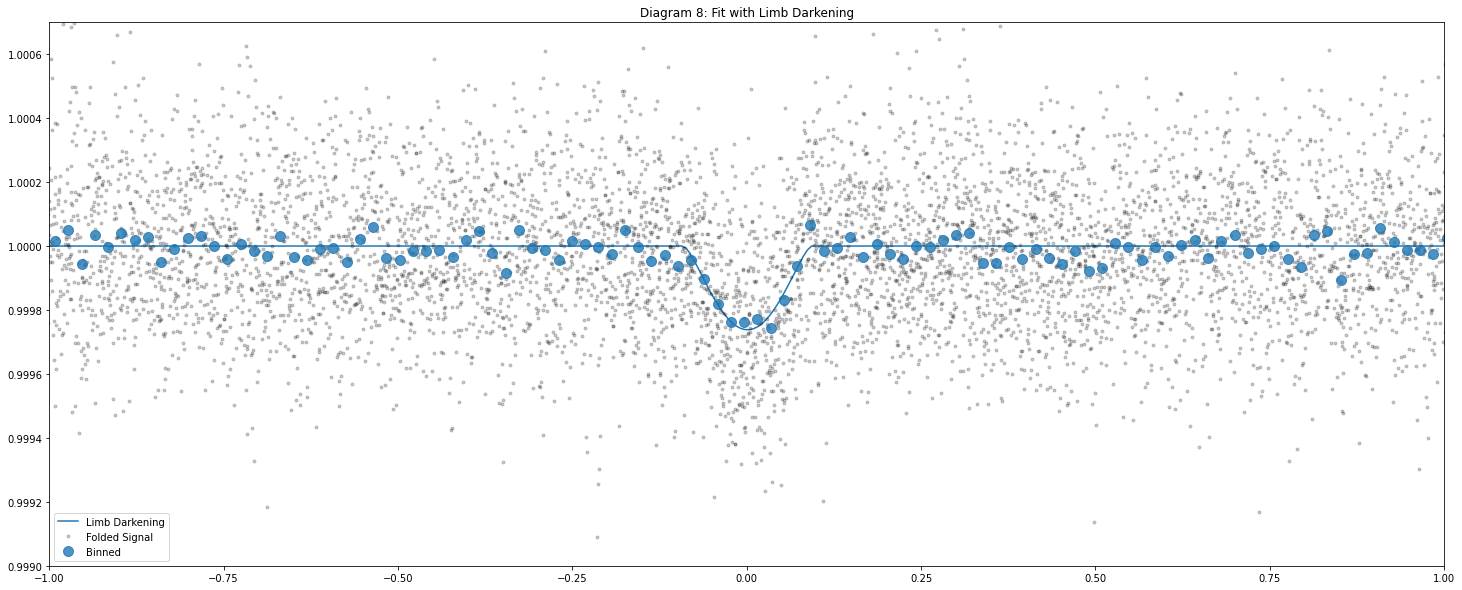

In [ ]:
popt2,pcov2 = curve_fit(transit,bin_transit.time_bin_center.jd,bin_transit["gp-detrend"],[0,1,1,1,1,1],maxfev=1400)
#Fit with some initial guesses by reading the plot by hand
#plt.plot(test,transit(test,0,PlanetParams[1],PlanetParams[0],popt[-1],1,2))
plt.title("Diagram 8: Fit with Limb Darkening")
plt.plot(test,transit(test,*popt2),label="Limb Darkening")
plt.plot(Flx_fold.time.jd,Flx_fold["gp-detrend"],".k",alpha=0.2,label="Folded Signal")
plt.plot(bin_transit.time_bin_center.jd,bin_transit["gp-detrend"],"oC0",markersize=10,alpha=0.8,label="Binned")
plt.ylim(0.9990,1.0007)
plt.xlim(-1,1)
plt.legend()

In [ ]:
popt2

array([ 1.19681473e-03,  1.93337927e+00,  9.44192016e-01,  1.83779619e-01,
       -1.66357701e+00, -1.49219136e+01])

We can see our fit is not working out, we can see this from the fact that the Fit Parameters are not coinciding with the expected values. To prove that our model works we shall plot the Model with the before retrived Values of our System. We decide to set the Limb Darkening Coefficients to 0 for simplicities sake.

(-1.0, 1.0)

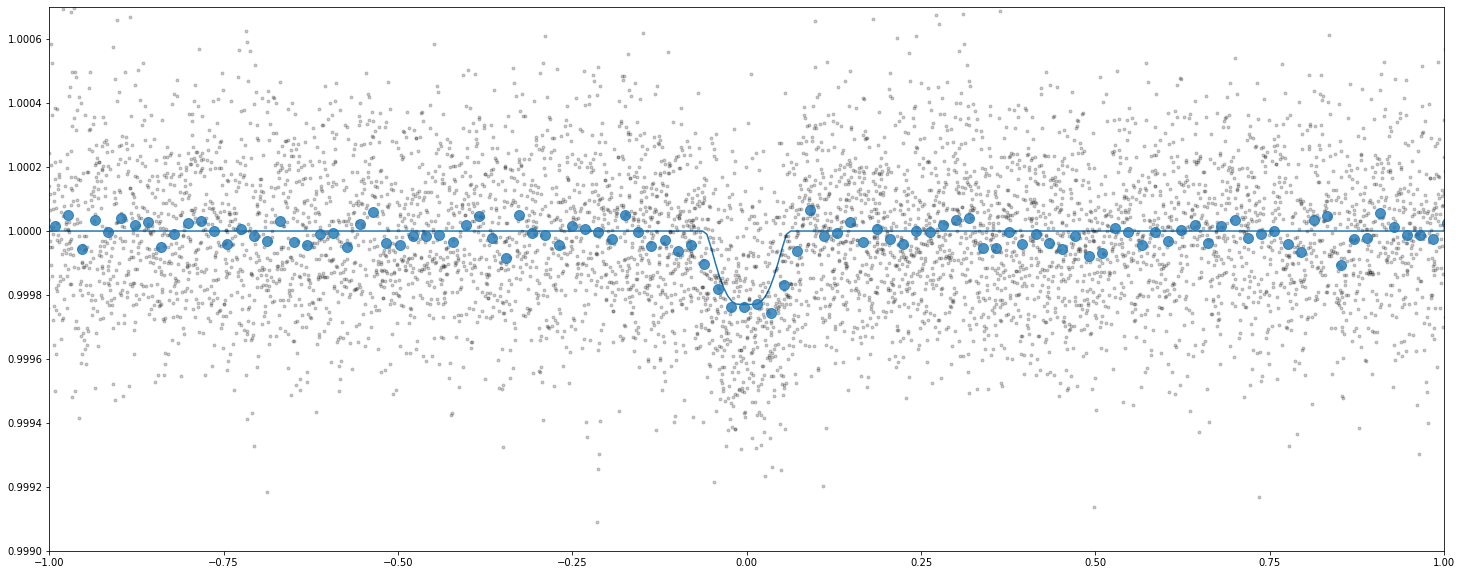

In [ ]:
plt.plot(test,transit(test,0,PlanetParams[1],PlanetParams[0],popt[-1],0,0))
plt.plot(Flx_fold.time.jd,Flx_fold["gp-detrend"],".k",alpha=0.2,label="Folded Signal")
plt.plot(bin_transit.time_bin_center.jd,bin_transit["gp-detrend"],"oC0",markersize=10,alpha=0.8,label="Binned")
plt.ylim(0.9990,1.0007)
plt.xlim(-1,1)

This shows us that the modell is not the problem as it can reproduce our lightcurve with no issues. Our Problem is thus the fact that we use a simple Chi Squared Method to fit our function, a better usage would be fitting with the help of a Monte Carlo Markov Chain (MCMC). This is a more specialized complicated function thus we will not write this by hand and instead use allready well proven Libraries for this. We will also use a Full Package for fitting the Transits from Start to Finish as oposed to do everything by hand as we have done so far to aquaint us with more powerfull tools than the rudimentary ones that we wrote ourselves.

Before we go and do this we quickly use the models in the PyAstronomy Package to make a simple fit with Limb Darkening.

In [ ]:
from PyAstronomy.modelSuite import palTrans

#creat a PalLC instance
plc = palTrans.PalLC()

# We want to fit the Fluxes so we use some Guess Parameters according to what we know from before
plc["p"] = 0.015     # Planet radius / Stellar radius
plc["per"] = period  # Orbital period
plc["a"] = 3     # Large semi major axis [R_S]
plc["i"] = 90.0    # Orbital inclination [deg]
# Specify limb darkening
# (quadratic limb-darkening law)
plc["linLimb"] = 0.4
plc["quadLimb"] = 0.2
# Specify T0 (central time of transit)
plc["T0"] = 0
# Specify binary contribution
plc["b"] = 0.0
# Assume we want to fit "p", "a", "i", and "T0"
plc.thaw(["T0", "i","p","a","per","linLimb","quadLimb"])

plc.fit(bin_transit.time_bin_center.jd,bin_transit["gp-detrend"])

print("Fit parameters: ")
plc.parameterSummary()

Fit parameters: 
-----------------------------------
Parameters for Component: PalCirc08
-----------------------------------
Parameter:        p  PalCirc08, [       p], value:    0.0210962, free:  True, restricted: False, related: False
Parameter:        a  PalCirc08, [       a], value:      3.27247, free:  True, restricted: False, related: False
Parameter:        i  PalCirc08, [       i], value:      107.272, free:  True, restricted: False, related: False
Parameter:  linLimb  PalCirc08, [ linLimb], value:     0.596916, free:  True, restricted: False, related: False
Parameter: quadLimb  PalCirc08, [quadLimb], value:      0.21624, free:  True, restricted: False, related: False
Parameter:       T0  PalCirc08, [      T0], value:  -0.00173054, free:  True, restricted: False, related: False
Parameter:      per  PalCirc08, [     per], value:      5.60386, free:  True, restricted: False, related: False
Parameter:        b  PalCirc08, [       b], value:            0, free: False, restricted: F

['-----------------------------------',
 'Parameters for Component: PalCirc08',
 '-----------------------------------',
 'Parameter:        p  PalCirc08, [       p], value:    0.0210962, free:  True, restricted: False, related: False',
 'Parameter:        a  PalCirc08, [       a], value:      3.27247, free:  True, restricted: False, related: False',
 'Parameter:        i  PalCirc08, [       i], value:      107.272, free:  True, restricted: False, related: False',
 'Parameter:  linLimb  PalCirc08, [ linLimb], value:     0.596916, free:  True, restricted: False, related: False',
 'Parameter: quadLimb  PalCirc08, [quadLimb], value:      0.21624, free:  True, restricted: False, related: False',
 'Parameter:       T0  PalCirc08, [      T0], value:  -0.00173054, free:  True, restricted: False, related: False',
 'Parameter:      per  PalCirc08, [     per], value:      5.60386, free:  True, restricted: False, related: False',
 'Parameter:        b  PalCirc08, [       b], value:            0, f

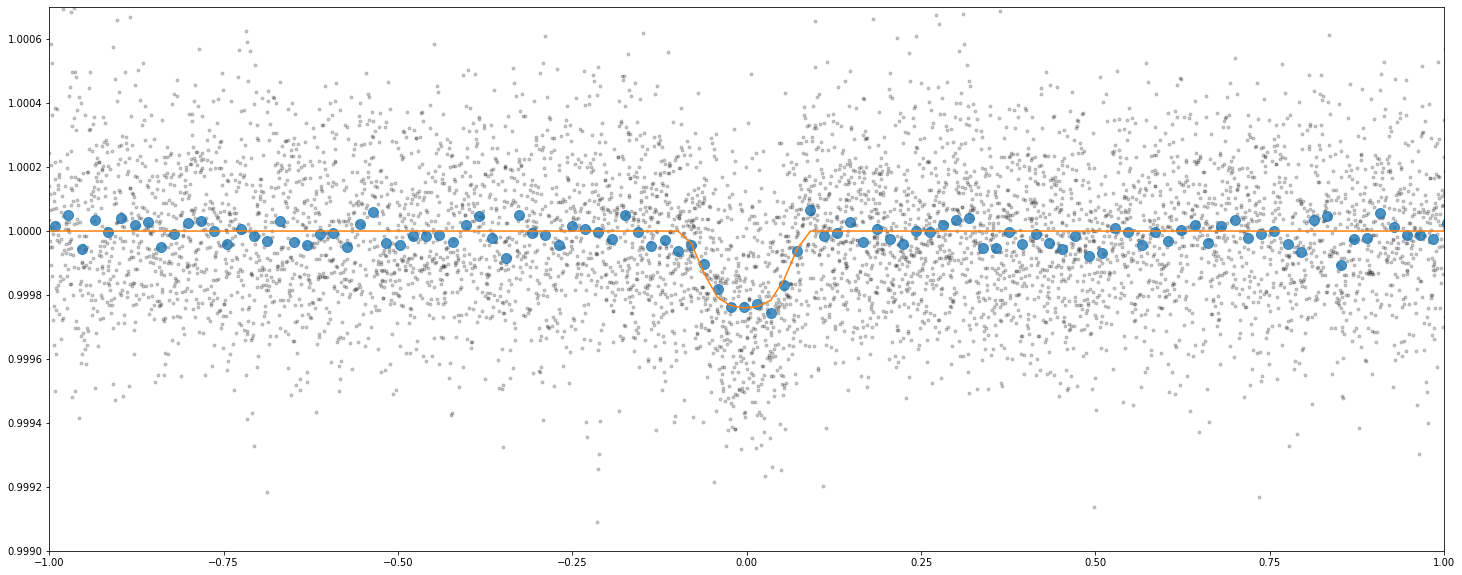

In [ ]:
plt.plot(Flx_fold.time.jd,Flx_fold["gp-detrend"],".k",alpha=0.2,label="Folded Signal")
plt.plot(bin_transit.time_bin_center.jd,bin_transit["gp-detrend"],"oC0",markersize=10,alpha=0.8,label="Binned")
plt.plot(bin_transit.time_bin_center.jd, plc.model, '-C1')
plt.ylim(0.9990,1.0007)
plt.xlim(-1,1)
plt.show()

As the final Part in these Series of Notebooks we want to go to the Notebook [Transit with Juliet](<Transit with Juliet.ipynb>) where we do the Same thing we have done now but using the All Purpose Exoplanet Package Juliet.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b43e0c11-0b97-4e39-8716-b644d99b659d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>